In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import sys
import platform
import logging
import argparse
import trino
import io
import boto3
from itertools import islice
from datetime import datetime, date, timedelta
import pendulum
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Add parent directory to path
repo_path = '/Users/apple/Documents/naarni/repo/dview-naarni-data-platform'
# repo_path = '/home/notebook/prod/nelson/dview-naarni-data-platform'
sys.path.append(os.path.join(repo_path, 'tasks'))

# Import necessary files and its respective functions
from common.db_operations import connect_to_trino, fetch_data_for_day, write_df_to_iceberg,drop_table,execute_query
from common.optimizer_logic import optimize_dataframe_memory

# Import business logic functions
from biz_logic.energy_mileage.energy_mileage_daily_v0 import energy_mileage_stats ,impute_odometer_readings

from biz_logic.energy_consumption.energy_consumption_report import energy_consumption_stats

# Configure basic logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

# Print the Python version being used
print(f"Using Python version: {platform.python_version()}")

Using Python version: 3.13.7


In [3]:
# ---- reporting config (edit ONLY this) ----
TABLE_NAME = "can_parsed_output_100"   # <— change only this

# derived (don’t edit)
REPORT_TABLE = f"adhoc.facts_prod.{TABLE_NAME}"
REPORT_S3_LOCATION = f"s3a://naarni-data-lake/aqua/warehouse/facts_prod.db/{TABLE_NAME}/"

In [ ]:
date_str = "2025-10-01"  # Date for which data is to be processed

# Parse the date string as a date object
target_date = datetime.strptime(date_str, "%Y-%m-%d").date()

# Create datetime objects for the start and end of the day in IST
ist_start = datetime.combine(target_date, datetime.min.time())
ist_end = ist_start + timedelta(days=31)

# Convert IST to UTC for the database query
# IST is UTC+5:30, so we subtract 5 hours and 30 minutes
utc_start = ist_start - timedelta(hours=5, minutes=30) 
utc_end = ist_end - timedelta(hours=5, minutes=30)

logging.info(f"🔍 Query window (UTC): {utc_start} → {utc_end}")
logging.info(f"🔍 Query window (IST): {ist_start} → {ist_end}")

2025-11-13 13:07:26 - INFO - 🔍 Query window (UTC): 2025-09-30 18:30:00 → 2025-10-03 18:30:00
2025-11-13 13:07:26 - INFO - 🔍 Query window (IST): 2025-10-01 00:00:00 → 2025-10-04 00:00:00


### AC Fault Code:
1. No_Fault
2. Low_Voltage
3. Outside_Temp_Sensor_Fault
4. High_Voltage
5. Exhaust_Temp_Protection
6. Eva_Temp_Sesnor_Fault
7. AC Communication Fail

### AC Status:
1. Start
2. Stop

### TMS Fault Code:
1. No Fault
2. Water_Sensor_Failure
3. Water_Pump_Failure
4. Water_IN_Sensor_Failure
5. Exhaust_Temp_Protection
6. Low_Water_Level_Alarm
7. LV Undervoltage

### TMS Working Mode:
1. Charging_Cooling
2. Fast_Discharge_Cooling
3. Self_Circulation
4. Low_Coolant
5. Off

### B2T TMS Control Cmd:
1. Charging_Cooling
2. Fast_Discharge_Cooling
3. Self_Circulation
4. Off

In [5]:
# query = f"""
# select 
#     id,date(timestamp + interval '5:30' hour to minute) as dateval,count(*) 
# FROM 
#     facts_prod.can_parsed_output_100
# where 
#     id in ('6') and 
#     timestamp >= TIMESTAMP '{utc_start.strftime('%Y-%m-%d %H:%M:%S')}' and
#     timestamp < TIMESTAMP '{utc_end.strftime('%Y-%m-%d %H:%M:%S')}'
# group by 1,2"""

# # conn = connect_to_trino(host="analytics.internal.naarni.com",port=443,user="admin",catalog="adhoc",schema="default")
# conn = connect_to_trino(host="trino.internal.naarni.com",port=443,user="admin",catalog="adhoc",schema="default")

# df = execute_query(conn, f"SELECT * FROM {REPORT_TABLE} LIMIT 5", return_results=True)
# display(df)

In [6]:
def fetch_battery_data(start_date, end_date, vehicle_ids):
    """
    Fetch raw battery data from the database for the specified date range and vehicle IDs.
    
    Args:
        start_date: Start date in 'YYYY-MM-DD' format
        end_date: End date in 'YYYY-MM-DD' format
        vehicle_ids: List of vehicle IDs
        
    Returns:
        Tuple of (df_cpo100, df_can_ac) containing raw data from both tables
    """
    logging.info(f"Fetching raw battery data from {start_date} to {end_date} for vehicles {vehicle_ids}")
    
    # Format vehicle IDs for the query
    vehicle_ids_str = ', '.join([f"'{vid}'" for vid in vehicle_ids])
    
    # Connect to Trino
    # conn = connect_to_trino(host="analytics.internal.naarni.com", port=443, user="admin", catalog="adhoc", schema="default")
    conn = connect_to_trino(host="trino.naarni.internal",port=80,user="admin",catalog="adhoc",schema="default")
    # conn = connect_to_trino(host="trino",port=8080,user="admin",catalog="adhoc",schema="default")
    # conn = trino.dbapi.connect(host="trino",port=8080,user="admin",catalog="adhoc",schema="facts_prod")

    # Query for cpo100 data
    cpo100_query = f"""
    SELECT 
        id,timestamp,dt, 
        batterycoolingstate, batterycoolanttemperature,
        temperaturedifferencealarm, chargingcurrentalarm, dischargecurrentalarm,
        vehiclereadycondition, gun_connection_status, ignitionstatus,
        vehicle_speed_vcu,gear_position,bat_soc,
        pack1_cellmax_temperature, pack1_cell_min_temperature, pack1_maxtemperature_cell_number,  pack1_celltemperature_cellnumber,
        bat_voltage,cellmax_voltagecellnumber,cell_max_voltage,cellminvoltagecellnumber,cell_min_voltage,
        lowpressureoilpumpfaultcode,bms_fault_code,vcu_fault_code,fiveinone_faultcode
    FROM 
        facts_prod.can_parsed_output_all
    WHERE 
        id IN ({vehicle_ids_str})
        AND dt between DATE('{start_date}')
        AND DATE('{end_date}')
    """

    # Query for can_ac data
    can_ac_query = f"""
    SELECT 
        id, timestamp, date,
        b2t_tms_control_cmd, b2t_set_water_out_temp, b2t_battery_min_temp, b2t_battery_max_temp,
        tms_working_mode, tms_fault_code, ac_fault_code, coolant_out_temp, coolant_in_temp,
        comp_status,comp_target_hz as comp_target_freq,
        comp_running_frequency as comp_running_freq,
        v2t_vehicle_coolant_low, comp_current, hv_voltage
    FROM 
        facts_prod.can_output_ac
    WHERE
        id IN ({vehicle_ids_str})
        AND dt >= DATE('{start_date}')
        AND dt <= DATE('{end_date}')
        and b2t_battery_min_temp > 0
        and b2t_battery_max_temp > 0
        and coolant_in_temp > 0
    """

    # Execute queries and fetch data
    cur = conn.cursor()

    # Fetch cpo100 data
    cur.execute(cpo100_query)
    cpo100_columns = [desc[0] for desc in cur.description]
    cpo100_rows = cur.fetchall()
    df_cpo100 = pd.DataFrame(cpo100_rows, columns=cpo100_columns)

    # Fetch can_ac data
    cur.execute(can_ac_query)
    can_ac_columns = [desc[0] for desc in cur.description]
    can_ac_rows = cur.fetchall()
    df_can_ac = pd.DataFrame(can_ac_rows, columns=can_ac_columns)

    logging.info(f"Done Fetching data.")
    logging.info(f"Retrieved {len(df_cpo100)} cpo100 records and {len(df_can_ac)} can_ac records")
    
    # Close connections
    cur.close()
    conn.close()
    
    return df_cpo100, df_can_ac

In [7]:
def process_battery_data(df_cpo100, df_can_ac):
    """
    Process raw battery data to create the final merged dataset.
    
    Args:
        df_cpo100: Raw DataFrame from can_parsed_output_100 table
        df_can_ac: Raw DataFrame from can_output_ac table
        
    Returns:
        Tuple of (result_df, df_cpo100_processed, df_can_ac_processed)
        where result_df is the final merged dataset and the others are processed versions
    """
    logging.info("Processing battery data")
    
    # Convert timestamp columns to datetime if they aren't already
    df_cpo100['timestamp'] = pd.to_datetime(df_cpo100['timestamp'])
    df_can_ac['timestamp'] = pd.to_datetime(df_can_ac['timestamp'])
    
    # Perform minute truncation in pandas
    df_cpo100['ts_mins'] = df_cpo100['timestamp'].dt.floor('min')
    df_can_ac['ts_mins_cac'] = df_can_ac['timestamp'].dt.floor('min')

    df_cpo100['ts_ist'] = (pd.to_datetime(df_cpo100['timestamp'], utc=True).dt.tz_convert('Asia/Kolkata'))
    df_can_ac['ts_ist'] = (pd.to_datetime(df_can_ac['timestamp'], utc=True).dt.tz_convert('Asia/Kolkata'))


    # Add row numbers (equivalent to SQL row_number() window function)
    # For cpo100
    df_cpo100 = df_cpo100.sort_values(['id', 'ts_mins', 'timestamp'])
    df_cpo100['cpo_rn'] = df_cpo100.groupby(['id', 'ts_mins']).cumcount() + 1

    # For can_ac
    df_can_ac = df_can_ac.sort_values(['id', 'ts_mins_cac', 'timestamp'])
    df_can_ac['cac_rn'] = df_can_ac.groupby(['id', 'ts_mins_cac']).cumcount() + 1

    # Perform the join in pandas (equivalent to SQL right join)
    merged_df = pd.merge(
        df_can_ac,
        df_cpo100,
        left_on=['id', 'ts_mins_cac', 'cac_rn'],
        right_on=['id', 'ts_mins', 'cpo_rn'],
        how='left',
        suffixes=('_can_ac','_cpo100')
    )

    # Select only the columns we need
    result_columns = []

    # Add id column
    if 'id' in merged_df.columns:
        result_columns.append('id')
    elif 'id_cpo100' in merged_df.columns:
        result_columns.append('id_cpo100')

    # Add other columns from cpo100
    cpo100_cols = ['ignitionstatus', 'vehiclereadycondition', 'gun_connection_status',
                   'vehicle_speed_vcu','gear_position','bat_soc',                
                   'pack1_cellmax_temperature', 'pack1_cell_min_temperature',
                   'pack1_maxtemperature_cell_number','pack1_celltemperature_cellnumber',
                   'bat_voltage','cellmax_voltagecellnumber','cell_max_voltage','cellminvoltagecellnumber','cell_min_voltage']
    
    for col in cpo100_cols:
        if col in merged_df.columns:
            result_columns.append(col)
        elif f'{col}_cpo100' in merged_df.columns:
            result_columns.append(f'{col}_cpo100')

    # Add timestamp (from cpo100)
    if 'timestamp_cpo100' in merged_df.columns:
        result_columns.append('timestamp_cpo100')
    elif 'timestamp' in merged_df.columns:
        result_columns.append('timestamp')

    # Add ts_mins (from cpo100)
    if 'ts_mins_cpo100' in merged_df.columns:
        result_columns.append('ts_mins_cpo100')
    elif 'ts_mins' in merged_df.columns:
        result_columns.append('ts_mins')

    # Add columns from can_ac
    can_ac_cols = ['ts_ist_can_ac','b2t_tms_control_cmd', 'b2t_set_water_out_temp', 
                  'b2t_battery_min_temp', 'b2t_battery_max_temp', 'tms_working_mode',
                  'coolant_out_temp', 'coolant_in_temp', 'hv_voltage',
                  'comp_target_freq','comp_running_freq',
                  'comp_status','tms_fault_code','ac_fault_code']

    for col in can_ac_cols:
        if col in merged_df.columns:
            result_columns.append(col)
        elif f'{col}_can_ac' in merged_df.columns:
            result_columns.append(f'{col}_can_ac')

    # Create result DataFrame with selected columns
    result_df = merged_df[result_columns].copy()

    # Rename columns to match original query output
    rename_dict = {}
    if 'id_cpo100' in result_df.columns:
        rename_dict['id_cpo100'] = 'id'
    if 'timestamp_cpo100' in result_df.columns:
        rename_dict['timestamp_cpo100'] = 'timestamp'
    if 'ts_mins_cpo100' in result_df.columns:
        rename_dict['ts_mins_cpo100'] = 'ts_mins'

    # Rename any columns with _can_ac suffix
    for col in result_df.columns:
        if col.endswith('_can_ac'):
            rename_dict[col] = col[:-7]  # Remove the '_can_ac' suffix

    result_df = result_df.rename(columns=rename_dict)

    # Sort the result as in the original query
    result_df = result_df.sort_values(['id', 'timestamp'])

    logging.info(f"Processed {len(result_df)} battery data records")
    return result_df, df_cpo100, df_can_ac

In [8]:
def get_all_battery_data(start_date, end_date, vehicle_ids):
    """
    Fetch and process all battery data for the specified date range and vehicle IDs.
    
    Args:
        start_date: Start date in 'YYYY-MM-DD' format
        end_date: End date in 'YYYY-MM-DD' format
        vehicle_ids: List of vehicle IDs
        
    Returns:
        DataFrame with battery data
    """
    # Fetch raw data
    df_cpo100, df_can_ac = fetch_battery_data(start_date, end_date, vehicle_ids)
    
    # Process the data
    result_df, df_cpo100_processed, df_can_ac_processed = process_battery_data(df_cpo100, df_can_ac)
    
    return result_df, df_cpo100_processed, df_can_ac_processed

In [9]:
utc_start.strftime("%Y-%m-%d"),utc_end.strftime("%Y-%m-%d")

('2025-09-30', '2025-10-03')

In [10]:
df, df_cpo100, df_can_ac = get_all_battery_data(utc_start.strftime("%Y-%m-%d"), utc_end.strftime("%Y-%m-%d"), ['6'])

2025-11-13 13:07:26 - INFO - Fetching raw battery data from 2025-09-30 to 2025-10-03 for vehicles ['6']
2025-11-13 13:07:26 - INFO - 🔌 STEP 1: Connecting to Trino...
2025-11-13 13:07:26 - INFO - ✅ STEP 1: Connected to Trino
2025-11-13 13:08:18 - INFO - Done Fetching data.
2025-11-13 13:08:18 - INFO - Retrieved 210144 cpo100 records and 92501 can_ac records
2025-11-13 13:08:18 - INFO - Processing battery data
2025-11-13 13:08:18 - INFO - Processed 92501 battery data records


In [11]:
df = df[(df.timestamp >= utc_start) & (df.timestamp <= utc_end)].copy()
print(df.timestamp.min(),df.timestamp.max())
print(df.ts_ist.min(),df.ts_ist.max())

2025-09-30 18:30:02.497000 2025-10-03 18:29:10.750000
2025-10-01 00:00:13.117000+05:30 2025-10-03 23:59:45.170000+05:30


In [12]:
display(len(df))
display(df.head(10))

82560

,id,ignitionstatus,vehiclereadycondition,gun_connection_status,vehicle_speed_vcu,gear_position,bat_soc,pack1_cellmax_temperature,pack1_cell_min_temperature,pack1_maxtemperature_cell_number,pack1_celltemperature_cellnumber,bat_voltage,cellmax_voltagecellnumber,cell_max_voltage,cellminvoltagecellnumber,cell_min_voltage,timestamp,ts_mins,ts_ist,b2t_tms_control_cmd,b2t_set_water_out_temp,b2t_battery_min_temp,b2t_battery_max_temp,tms_working_mode,coolant_out_temp,coolant_in_temp,hv_voltage,comp_target_freq,comp_running_freq,comp_status,tms_fault_code,ac_fault_code
7599,6,1.0,1.0,0.0,47.867188,2.0,92.0,31.0,27.0,74.0,9.0,635.9,38.0,3.314,475.0,3.311,2025-09-30 18:30:02.497,2025-09-30 18:30:00,2025-10-01 00:00:13.117000+05:30,Off,15,27,31,Off,19,18,630.0,50.0,0.0,Off,No Fault,No_Fault
7600,6,1.0,1.0,0.0,48.992188,2.0,92.0,31.0,27.0,74.0,9.0,635.8,64.0,3.314,527.0,3.310,2025-09-30 18:30:03.897,2025-09-30 18:30:00,2025-10-01 00:00:19.117000+05:30,Off,15,27,31,Off,19,18,628.0,50.0,0.0,Off,No Fault,No_Fault
7601,6,1.0,1.0,0.0,50.777344,2.0,92.0,31.0,27.0,79.0,9.0,635.6,64.0,3.314,35.0,3.310,2025-09-30 18:30:05.757,2025-09-30 18:30:00,2025-10-01 00:00:30.018000+05:30,Off,15,27,31,Off,19,19,628.0,50.0,0.0,Off,No Fault,No_Fault
7602,6,1.0,1.0,0.0,52.457030,2.0,92.0,NaN,NaN,NaN,NaN,635.2,NaN,NaN,NaN,NaN,2025-09-30 18:30:08.078,2025-09-30 18:30:00,2025-10-01 00:00:36.078000+05:30,Off,15,27,31,Off,19,19,NaN,NaN,NaN,None,No Fault,None
7603,6,1.0,1.0,0.0,53.359375,2.0,91.6,31.0,27.0,79.0,9.0,634.7,28.0,3.309,457.0,3.305,2025-09-30 18:30:11.237,2025-09-30 18:30:00,2025-10-01 00:00:39.097000+05:30,Off,15,27,31,Off,19,19,632.0,50.0,0.0,Off,No Fault,No_Fault
7604,6,1.0,1.0,0.0,53.003906,2.0,91.6,31.0,27.0,74.0,9.0,634.5,28.0,3.308,517.0,3.303,2025-09-30 18:30:13.117,2025-09-30 18:30:00,2025-10-01 00:00:45.077000+05:30,Off,15,27,31,Off,19,19,NaN,NaN,NaN,None,No Fault,None
7605,6,1.0,1.0,0.0,50.777344,2.0,NaN,31.0,27.0,74.0,9.0,NaN,28.0,3.307,477.0,3.303,2025-09-30 18:30:16.057,2025-09-30 18:30:00,2025-10-01 00:00:55.097000+05:30,Off,15,27,31,Off,19,19,NaN,NaN,NaN,None,No Fault,None
7606,6,1.0,1.0,0.0,50.093750,2.0,91.6,31.0,27.0,74.0,9.0,634.0,28.0,3.303,550.0,3.297,2025-09-30 18:30:19.137,2025-09-30 18:30:00,2025-10-01 00:00:58.077000+05:30,Off,15,27,31,Off,19,19,NaN,NaN,NaN,None,No Fault,None
7607,6,1.0,1.0,0.0,38.660156,2.0,91.6,31.0,27.0,79.0,9.0,638.5,277.0,3.342,468.0,3.325,2025-09-30 18:31:01.077,2025-09-30 18:31:00,2025-10-01 00:01:01.057000+05:30,Off,15,27,31,Off,19,19,NaN,NaN,NaN,None,No Fault,None
7608,6,1.0,1.0,0.0,31.140625,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-30 18:31:02.457,2025-09-30 18:31:00,2025-10-01 00:01:07.237000+05:30,Off,15,27,31,Off,19,19,NaN,NaN,NaN,None,No Fault,None


In [13]:
df_can_ac.comp_running_freq.describe()

count    59762.000000
mean        22.982849
std         24.792206
min          0.000000
25%          0.000000
50%          0.000000
75%         50.000000
max         50.000000
Name: comp_running_freq, dtype: float64

In [14]:
df_can_ac.comp_running_freq.value_counts(dropna=False).sort_values()

comp_running_freq
2.0         1
33.0       13
45.0       20
3.0        39
23.0       45
28.0       48
18.0       53
49.0       56
39.0       57
8.0        62
14.0       70
13.0       73
24.0       91
44.0      109
34.0      122
50.0    27004
0.0     31899
NaN     32739
Name: count, dtype: int64

In [15]:
df_cpo100.batterycoolingstate.describe()

count       0
unique      0
top       NaN
freq      NaN
Name: batterycoolingstate, dtype: object

In [16]:
df_cpo100.bat_soc.isnull().sum()

np.int64(31438)

In [17]:
# display(df_cpo100.head())
# display(df_cpo100.lowpressureoilpumpfaultcode.value_counts())
# display(df_cpo100.bms_fault_code.value_counts())
# display(df_cpo100.fiveinone_faultcode.value_counts())

In [18]:
def safe_freq(series):
    """Convert to numeric, drop garbage, and fill short missing runs smoothly."""
    if series is None:
        return None
    s = pd.to_numeric(series, errors="coerce")
    
    # If everything is NaN, return as-is (don’t invent values)
    if s.dropna().empty:
        return s
    
    # Light smoothing: forward-fill then back-fill to close small gaps
    s = s.ffill().bfill()
    
    return s

def safe_get(df, col):
    return df[col] if col in df.columns else pd.Series(dtype=float)

def safe_min(series):
    """Return min safely without warnings on empty or all-NaN slices."""
    s = pd.to_numeric(series, errors='coerce').dropna()
    return round(s.min(), 3) if len(s) > 0 else np.nan

def safe_max(series):
    """Return max safely without warnings on empty or all-NaN slices."""
    s = pd.to_numeric(series, errors='coerce').dropna()
    return round(s.max(), 3) if len(s) > 0 else np.nan

def safe_median(series):
    """Return median safely without warnings on empty or all-NaN slices."""
    s = pd.to_numeric(series, errors='coerce').dropna()
    return round(s.median(), 3) if len(s) > 0 else np.nan

def safe_mean(series):
    """Return mean safely without warnings on empty or all-NaN slices."""
    s = pd.to_numeric(series, errors='coerce').dropna()
    return round(s.mean(), 3) if len(s) > 0 else np.nan


def scalar_mode(s: pd.Series):
    """Return a single scalar mode value from a pandas Series."""
    s = s.dropna()
    if s.empty:
        return np.nan
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else np.nan


def process_tms_transitions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identify transitions in TMS state parameters and summarize continuous states
    with temperature and cell voltage details.
    """
    # --- Preprocess timestamp ---
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.sort_values('timestamp').reset_index(drop=True)

    # --- Clean compressor status ---
    df["comp_status"] = (df["comp_status"].ffill().replace({"nan": np.nan}))
    # ensure first value isn't NaN to avoid false trigger at start
    if pd.isna(df.loc[0, "comp_status"]):
        df.loc[0, "comp_status"] = "Off"  # or whichever baseline makes sense

    df["comp_target_freq"] = df["comp_target_freq"].ffill().replace({"nan": np.nan})
    # ensure first value isn't NaN to avoid false trigger at start
    if pd.isna(df.loc[0, "comp_target_freq"]):
        df.loc[0, "comp_target_freq"] = 0  # or whichever baseline makes sense

    df["comp_running_freq"] = df["comp_running_freq"].ffill().replace({"nan": np.nan})
    # ensure first value isn't NaN to avoid false trigger at start
    if pd.isna(df.loc[0, "comp_running_freq"]):
        df.loc[0, "comp_running_freq"] = 0  # or whichever baseline makes sense


    # --- Clean AC fault code ---
    df["ac_fault_code"] = (df["ac_fault_code"].ffill().replace({"nan": np.nan}))
    # ensure first value isn't NaN to avoid false trigger at start
    if pd.isna(df.loc[0, "ac_fault_code"]):
        df.loc[0, "ac_fault_code"] = "No Fault"  # or whichever baseline makes sense

    rename_map = {
        "b2t_battery_min_temp": "batt_mintemp",
        "b2t_battery_max_temp": "batt_maxtemp",        
        "coolant_in_temp": "coolant_in",
        "coolant_out_temp": "coolant_out",
        "bat_soc": "soc",
        "pack1_celltemperature_cellnumber": "mintemp_cellnum",
        "pack1_maxtemperature_cell_number": "maxtemp_cellnum",
        "cellminvoltagecellnumber": "minvolt_cellnum",
        "cellmax_voltagecellnumber": "maxvolt_cellnum",
        "cell_max_voltage": "max_cellvolt",
        "cell_min_voltage": "min_cellvolt",
        "vehiclereadycondition": "veh_status",
        "gun_connection_status": "gun_status",
    }
    df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

    # --- Define key columns ---
    transition_cols = ["b2t_tms_control_cmd", "tms_working_mode"]
    # "b2t_set_water_out_temp", 
    temp_cols = ["batt_mintemp", "batt_maxtemp", "coolant_out", "coolant_in", 
                 "mintemp_cellnum", "maxtemp_cellnum", "minvolt_cellnum", "maxvolt_cellnum",
                 "max_cellvolt", "min_cellvolt", "bat_voltage", "hv_voltage", "soc"]
    
    # --- Identify transitions ---
    change_mask = (df[transition_cols] != df[transition_cols].shift()).any(axis=1)
    df["state_group"] = change_mask.cumsum()

    # --- Summarize each state group ---
    summary_list = []
    for group_id, group in df.groupby("state_group"):
        if group.empty:
            continue

        start_row = group.iloc[0]
        end_row = group.iloc[-1]

        # Determine vehicle mode
        ignition = start_row.get("ignitionstatus", np.nan)
        vehicle_ready = start_row.get("veh_status", np.nan)
        gun_status = start_row.get("gun_status", np.nan)
        if vehicle_ready == 1.0:
            mode = "Drive"
        elif gun_status == 1.0:
            mode = "Charging/Park"
        else:
            mode = "Idle/Other"

        # --- Compressor metrics within the group ---
        comp_col = "comp_status"
        if comp_col in group.columns:
            comp = group[["timestamp", comp_col]].copy()
            comp[comp_col] = comp[comp_col].astype(str).str.strip().str.lower()
            comp["next_time"] = comp["timestamp"].shift(-1)
            comp["interval_min"] = (comp["next_time"] - comp["timestamp"]).dt.total_seconds() / 60.0

            # Calculate total minutes in each state
            on_time = comp.loc[comp[comp_col] == "on", "interval_min"].sum(skipna=True)
            off_time = comp.loc[comp[comp_col] == "off", "interval_min"].sum(skipna=True)
            duty_cycle = (on_time * 100.0) / (on_time + off_time) if (on_time + off_time) > 0 else np.nan
        else:
            on_time = off_time = duty_cycle = np.nan


        # Build summary record
        record = {
            "start_time": start_row["timestamp"],
            "end_time": end_row["timestamp"],
            "duration_mins": round((end_row["timestamp"] - start_row["timestamp"]).total_seconds() / 60.0, 2),
            "mode": mode,
            "vehicle_speed_start": round(start_row.get("vehicle_speed_vcu", np.nan), 1),
            "ignitionstatus_start": start_row.get("ignitionstatus", np.nan),
            "veh_status_start": start_row.get("veh_status", np.nan),
            "gun_status_start": start_row.get("gun_status", np.nan),
            **{f"{col}_start": start_row[col] for col in temp_cols},
            **{f"{col}_end": end_row[col] for col in temp_cols},
            **{col: start_row[col] for col in transition_cols},
            
            # Temperature statistics
            "batt_mintemp_lowest": safe_min(group["batt_mintemp"]),
            "batt_maxtemp_highest": safe_max(group["batt_maxtemp"]),
            "batt_mintemp_med": safe_median(group["batt_mintemp"]),
            "batt_maxtemp_med": safe_median(group["batt_maxtemp"]),
            "coolant_out_med": safe_median(group["coolant_out"]),
            "coolant_in_med": safe_median(group["coolant_in"]),

            # Temperature cell data
            "mintemp_cellnum_mode": scalar_mode(group["mintemp_cellnum"]),            
            "maxtemp_cellnum_mode": scalar_mode(group["maxtemp_cellnum"]),

            # Compressor metrics
            "comp_status_on_time": round(on_time, 2),
            "comp_status_off_time": round(off_time, 2),
            "comp_duty_cycle": round(duty_cycle, 2),

            # Voltage cell data
            "minvolt_cellnum_mode": scalar_mode(safe_get(group, "minvolt_cellnum")),
            "maxvolt_cellnum_mode": scalar_mode(safe_get(group, "maxvolt_cellnum")),
            "min_cellvolt_med": safe_median(group["min_cellvolt"]),
            "max_cellvolt_med": safe_median(group["max_cellvolt"]),
            "bat_voltage_med": safe_median(group["bat_voltage"]),
        }

        summary_list.append(record)

    # --- Build final DataFrame ---
    state_summary = pd.DataFrame(summary_list)
    state_summary = state_summary[state_summary["duration_mins"] > 0]

    # --- Reorder columns for readability ---
    ordered_cols = [
        "start_time", "end_time", "duration_mins", "mode", "b2t_tms_control_cmd", "tms_working_mode",
        "vehicle_speed_start", "veh_status_start", "gun_status_start","soc_start","soc_end",
        "batt_maxtemp_start", "batt_maxtemp_end", "batt_maxtemp_med","batt_maxtemp_highest",
        "batt_mintemp_start", "batt_mintemp_end", "batt_mintemp_med","batt_mintemp_lowest",
        "mintemp_cellnum_start", "mintemp_cellnum_end", "mintemp_cellnum_mode",
        "maxtemp_cellnum_start", "maxtemp_cellnum_end", "maxtemp_cellnum_mode",
        "comp_status_on_time","comp_status_off_time","comp_duty_cycle",
        "coolant_out_start", "coolant_out_end", "coolant_out_med",
        "coolant_in_start", "coolant_in_end", "coolant_in_med", 
        "min_cellvolt_start", "min_cellvolt_end","min_cellvolt_med",                
        "minvolt_cellnum_start", "minvolt_cellnum_end", "minvolt_cellnum_mode",
        "max_cellvolt_start", "max_cellvolt_end","max_cellvolt_med",        
        "maxvolt_cellnum_start", "maxvolt_cellnum_end", "maxvolt_cellnum_mode",
        "bat_voltage_start", "bat_voltage_end", "bat_voltage_med"
    ]

    # --- Clean up integer-like columns ---
    int_like_cols = [
        "vehilceready_start", "gun_connection_status_start",
        "mintemp_cellnum_start", "mintemp_cellnum_end", "mintemp_cellnum_mode",
        "maxtemp_cellnum_start", "maxtemp_cellnum_end", "maxtemp_cellnum_mode",
        "minvolt_cellnum_start", "minvolt_cellnum_end", "minvolt_cellnum_mode",
        "maxvolt_cellnum_start", "maxvolt_cellnum_end", "maxvolt_cellnum_mode"
    ]

    for col in int_like_cols:
        if col in state_summary.columns:
            # Convert float values that are actually integers into proper integers
            state_summary[col] = (
                pd.to_numeric(state_summary[col], errors='coerce')
                .astype("Int64")  # Pandas nullable integer type (keeps NaN clean)
            )


    return df, state_summary.reindex(columns=ordered_cols)
    # return state_summary

- batt_mintemp, mintemp_cellnum
- batt_maxtemp, maxtemp_cellnum
- coolant_out
- coolant_in
- min_cellvolt, minvolt_cellnum
- max_cellvolt, maxvolt_cellnum
- bat_volt

In [19]:
# --- Example usage ---
# Correct usage
df_with_state,state_summary = process_tms_transitions(df)
state_summary

,start_time,end_time,duration_mins,mode,b2t_tms_control_cmd,tms_working_mode,vehicle_speed_start,veh_status_start,gun_status_start,soc_start,soc_end,batt_maxtemp_start,batt_maxtemp_end,batt_maxtemp_med,batt_maxtemp_highest,batt_mintemp_start,batt_mintemp_end,batt_mintemp_med,batt_mintemp_lowest,mintemp_cellnum_start,mintemp_cellnum_end,mintemp_cellnum_mode,maxtemp_cellnum_start,maxtemp_cellnum_end,maxtemp_cellnum_mode,comp_status_on_time,comp_status_off_time,comp_duty_cycle,coolant_out_start,coolant_out_end,coolant_out_med,coolant_in_start,coolant_in_end,coolant_in_med,min_cellvolt_start,min_cellvolt_end,min_cellvolt_med,minvolt_cellnum_start,minvolt_cellnum_end,minvolt_cellnum_mode,max_cellvolt_start,max_cellvolt_end,max_cellvolt_med,maxvolt_cellnum_start,maxvolt_cellnum_end,maxvolt_cellnum_mode,bat_voltage_start,bat_voltage_end,bat_voltage_med
0,2025-09-30 18:30:02.497,2025-09-30 23:56:31.996,326.49,Drive,Off,Off,47.9,1.0,0.0,92.0,55.2,31,35,33.0,35,27,29,28.0,27,9,7,9,74,81,73,116.28,210.21,35.62,19,17,19.0,18,17,18.0,3.311,3.247,3.304,475,455,454,3.314,3.253,3.310,38,92,86,635.9,623.9,634.80
2,2025-09-30 23:56:34.076,2025-10-01 01:33:18.115,96.73,Drive,Fast_Discharge_Cooling,Fast_Discharge_Cooling,81.0,1.0,0.0,55.2,43.2,35,29,32.0,35,29,24,27.0,24,7,9,9,81,107,80,56.67,40.07,58.58,17,24,20.0,17,23,21.0,3.249,3.270,3.269,525,193,48,3.255,3.274,3.275,28,280,422,624.3,628.0,628.00
4,2025-10-01 01:33:20.195,2025-10-01 01:39:06.653,5.77,Drive,Self_Circulation,Self_Circulation,0.0,1.0,0.0,43.2,43.2,29,28,28.0,29,24,24,24.0,24,9,9,9,107,80,80,0.00,5.77,0.00,24,24,24.0,23,24,24.0,3.270,3.275,3.273,48,145,48,3.274,3.279,3.277,91,280,280,628.0,628.9,628.70
5,2025-10-01 01:39:07.693,2025-10-01 01:59:09.313,20.03,Idle/Other,Off,Off,0.0,0.0,0.0,43.2,50.4,28,30,29.0,30,24,25,25.0,24,9,16,9,80,107,80,0.00,20.03,0.00,24,25,24.0,24,24,24.0,3.276,3.348,3.345,48,44,108,3.279,3.356,3.352,172,479,479,629.1,643.2,642.60
6,2025-10-01 01:59:10.293,2025-10-01 03:29:21.517,90.19,Charging/Park,Charging_Cooling,Charging_Cooling,0.0,0.0,1.0,50.4,100.0,30,31,31.0,32,25,27,27.0,25,15,9,9,107,80,80,49.07,41.11,54.41,25,21,21.0,24,23,22.0,3.348,3.385,3.390,44,413,28,3.355,3.501,3.399,479,574,479,643.3,654.0,651.50
7,2025-10-01 03:38:50.898,2025-10-01 07:55:07.839,256.28,Idle/Other,Off,Off,0.0,0.0,0.0,100.0,68.4,30,35,31.0,35,27,30,28.0,27,0,8,9,0,73,81,134.07,122.21,52.31,21,16,19.0,23,13,16.0,0.000,3.264,3.309,0,550,82,0.000,3.278,3.315,0,256,64,0.0,628.0,635.60
8,2025-10-01 07:55:08.817,2025-10-01 08:16:18.594,21.16,Drive,Fast_Discharge_Cooling,Fast_Discharge_Cooling,77.6,1.0,0.0,68.4,65.6,35,34,35.0,35,30,30,30.0,30,8,9,9,73,81,79,18.23,2.93,86.16,17,19,20.0,13,22,24.0,3.267,3.298,3.291,413,413,413,3.279,3.316,3.306,64,478,476,628.3,634.7,633.30
9,2025-10-01 08:17:00.414,2025-10-01 08:17:12.994,0.21,Charging/Park,Charging_Cooling,Off,NaN,NaN,1.0,65.6,65.6,34,34,34.0,34,30,30,30.0,30,9,9,9,81,81,81,0.00,0.21,0.00,19,20,20.0,22,22,22.0,3.300,3.299,3.299,454,490,490,3.318,3.319,3.318,476,472,472,635.1,635.1,635.10
10,2025-10-01 08:17:14.093,2025-10-01 08:37:01.713,19.79,Charging/Park,Charging_Cooling,Charging_Cooling,0.0,0.0,1.0,65.6,80.0,34,36,36.0,36,30,31,31.0,30,9,9,9,81,74,73,0.97,18.83,4.89,20,19,16.0,22,22,22.0,3.299,3.351,3.389,490,94,96,3.319,3.354,3.397,472,42,225,635.1,643.6,651.30
11,2025-10-01 08:44:14.614,2025-10-01 08:57:21.634,13.12,Idle/Other,Off,Off,NaN,NaN,NaN,NaN,78.0,34,35,34.0,35,30,30,30.0,30,<NA>,9,9,<NA>,73,81,12.17,0.94,92.81,22,19,19.0,22,18,20.0,NaN,3.290,3.331,<NA>,431,82,NaN,3.297,3.334,<NA>,86,64,NaN,632.2,639.60


In [20]:

def plot_session_summary(state_summary: pd.DataFrame):
    """
    Visualize session-wise deltas (start → end) from the state_summary dataframe.
    Shows how temperature, coolant, and voltage shifted in each transition.
    """
    if not {"batt_maxtemp_start", "batt_maxtemp_end"}.issubset(state_summary.columns):
        raise KeyError("state_summary missing expected start/end columns. Verify output of process_tms_transitions().")

    summary = state_summary.copy()
    summary["batt_maxtemp_delta"] = summary["batt_maxtemp_end"] - summary["batt_maxtemp_start"]
    summary["batt_mintemp_delta"] = summary["batt_mintemp_end"] - summary["batt_mintemp_start"]
    summary["coolant_out_delta"] = summary["coolant_out_end"] - summary["coolant_out_start"]
    summary["coolant_in_delta"] = summary["coolant_in_end"] - summary["coolant_in_start"]
    summary["bat_voltage_delta"] = summary["bat_voltage_end"] - summary["bat_voltage_start"]

    plt.figure(figsize=(10, 6))
    plt.plot(summary.index, summary["batt_mintemp_delta"], label="Batt Min Temp Δ", marker="o")
    plt.plot(summary.index, summary["batt_maxtemp_delta"], label="Batt Max Temp Δ", marker="o")
    plt.plot(summary.index, summary["coolant_out_delta"], label="Coolant Out Δ", marker="o")
    plt.plot(summary.index, summary["coolant_in_delta"], label="Coolant In Δ", marker="o")
    plt.plot(summary.index, summary["bat_voltage_delta"], label="Battery Voltage Δ", marker="o")

    plt.title("Session-wise Parameter Change (End − Start)")
    plt.xlabel("Session Index")
    plt.ylabel("Δ Value (°C or V)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [21]:
def plot_tms_session(df: pd.DataFrame, group_id: int):
    """
    Plot TMS temperature and compressor frequency evolution for a given state_group.
    Returns the figure object for PDF export.
    """

    if "state_group" not in df.columns:
        raise KeyError("Column 'state_group' not found.")

    session = df[df["state_group"] == group_id].copy()
    if session.empty:
        print(f"No data found for state_group {group_id}")
        return None

    # -------- Timestamp Fix --------
    session = session.sort_values("timestamp")
    try:
        session["timestamp"] = session["timestamp"].dt.tz_localize(None)
    except:
        pass
    session["timestamp"] = session["timestamp"].ffill().bfill()
    required_cols = [
        "batt_mintemp", "batt_maxtemp",
        "coolant_in", "coolant_out",
        "comp_target_freq", "comp_running_freq"
    ]

    # Skip if all values are null or missing
    if session[required_cols].isna().all().all():
        return None


    # -------- Figure Setup --------
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # -------- Temperature Plots --------
    ax1.plot(session["timestamp"], session["batt_mintemp"], label="Batt Min Temp", linewidth=2)
    ax1.plot(session["timestamp"], session["batt_maxtemp"], label="Batt Max Temp", linewidth=2)
    ax1.plot(session["timestamp"], session["coolant_in"], label="Coolant In", linestyle="--")
    ax1.plot(session["timestamp"], session["coolant_out"], label="Coolant Out", linestyle="--")

    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("Temperature (°C)")
    ax1.grid(alpha=0.3)

    # -------- Compressor Frequency Plots --------
    ax2 = ax1.twinx()
    ax2.plot(session["timestamp"], session["comp_target_freq"],
             linestyle="--", color="tab:pink", label="Comp Target Freq", alpha=0.7)
    ax2.plot(session["timestamp"], session["comp_running_freq"],
             linestyle="-", color="tab:gray", label="Comp Running Freq", alpha=0.7)

    ax2.set_ylabel("Compressor Frequency (Hz)")

    # -------- Combined Legend (NO duplicate legends) --------
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()

    fig.legend(
        lines_1 + lines_2,
        labels_1 + labels_2,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=3,
        frameon=True
    )

    # -------- Title --------
    mode = session["tms_working_mode"].iloc[0]
    cmd = session["b2t_tms_control_cmd"].iloc[0]
    fig.suptitle(f"TMS Session {group_id} | Mode: {mode} | Cmd: {cmd}", fontsize=14)

    # -------- Layout --------
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.close(fig)

    # ✅ DO NOT call plt.show() — breaks PDF capturing
    return fig


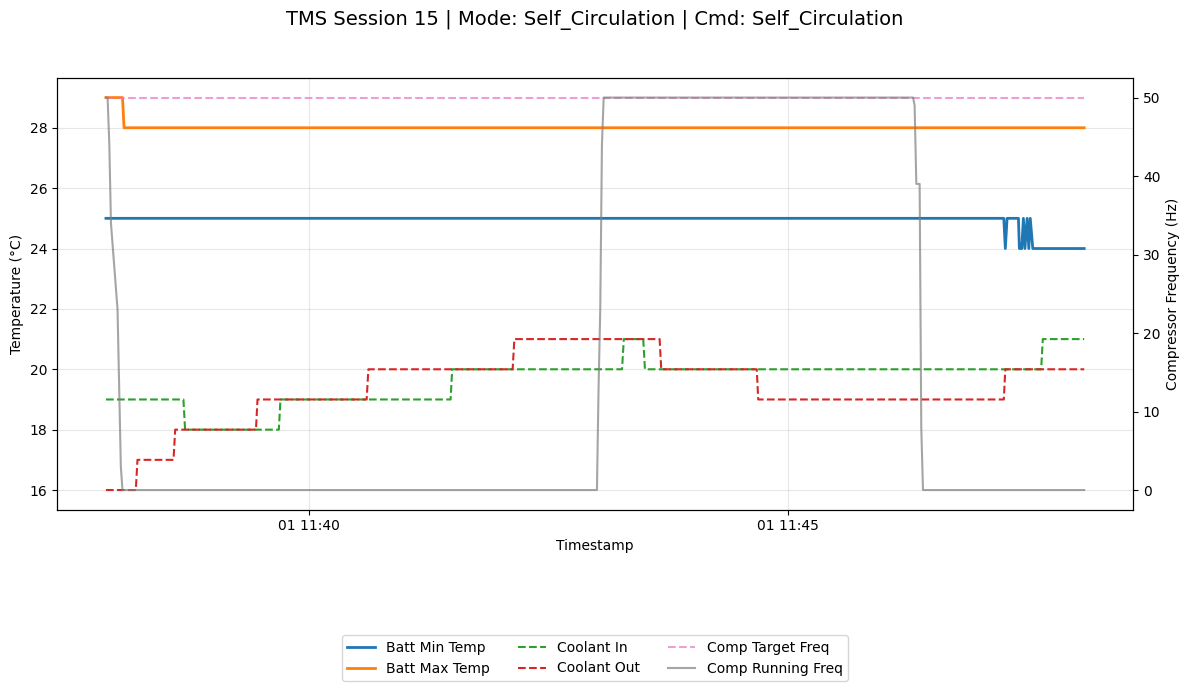

In [22]:
# Plot detailed single session (raw time-series)
plot_tms_session(df_with_state,group_id=15)

# Plot summary overview (start-end deltas)
# plot_session_summary(state_summary)


In [23]:
def save_all_tms_sessions(df, pdf_path="tms_sessions_report.pdf"):
    if "state_group" not in df.columns:
        raise KeyError("'state_group' not found in dataframe.")

    groups = sorted(df["state_group"].dropna().unique())
    skipped = []

    with PdfPages(pdf_path) as pdf:
        for gid in groups:
            fig = plot_tms_session(df, gid)

            if fig is None:
                skipped.append(gid)
                continue

            pdf.savefig(fig, bbox_inches="tight")
            plt.close(fig)

    print(f"✅ PDF generated: {pdf_path}")
    if skipped:
        print(f"ℹ️ Skipped sessions with no usable data: {skipped}")


save_all_tms_sessions(df_with_state, "tms_sessions_report.pdf")

✅ PDF generated: tms_sessions_report.pdf


In [24]:
len(df_with_state)

82560

1. Compressor Duty Cycle Analysis: based on 300seconds buckets for each state_group
2. What is the trigger for self circulation
3. When does the 